"""
Portfolio: Binary Prediction with a Rainfall Dataset

Author: YI LUO
Date: 20250331

Introduction:
-------------
This portfolio presents a comprehensive data analysis and modeling workflow using the Rainfall Dataset 
from the Kaggle competition "Playground Series - Season 5, Episode 3" 
(data source: https://www.kaggle.com/competitions/playground-series-s5e3/data). The primary goal of this project 
is to predict the probability of rainfall occurrence (binary classification) for each record in the test set.

Key Steps and Findings:
-----------------------
1. Data Exploration & Analysis:
   - We loaded the training and test datasets and performed an initial exploration to understand their structure,
     check for missing values, and examine basic statistics.
   - Visualizations such as histograms and a correlation heatmap were used to reveal feature distributions and 
     relationships. These insights guided our feature engineering process.

2. Data Preprocessing & Feature Engineering:
   - Missing values were handled by filling them with the median of each feature.
   - New features were derived to capture additional insights; for example, the 'temp_range' was calculated as 
     the difference between 'maxtemp' and 'mintemp', and interaction features like 'hci' (humidity * cloud) were created.
   - Categorical variables were encoded to ensure compatibility with machine learning models.

3. Data Augmentation:
   - To improve model robustness and prevent overfitting, we augmented the training data by generating synthetic 
     copies using small Gaussian noise. This approach effectively tripled the dataset size, allowing the model to 
     better generalize on unseen data.

4. Model Building & Evaluation:
   - A 6-layer Deep Neural Network (DNN) was constructed using TensorFlow/Keras. The model incorporates Batch 
     Normalization, ReLU activations, and Dropout for enhanced performance and regularization.
   - The model was trained using early stopping based on validation loss to prevent overfitting.
   - Key performance metrics such as accuracy and AUC were monitored during training.

5. Prediction & Submission:
   - The trained model outputs probabilities (between 0 and 1) for rainfall, which are rounded to one decimal place 
     to meet the submission format.
   - A submission file is generated in the required CSV format, ready for upload to Kaggle.

This portfolio not only demonstrates effective data preprocessing and feature engineering techniques but also 
highlights the iterative process of model building and evaluation in a real-world machine learning project. 
It serves as a testament to my analytical and problem-solving skills, and my ability to apply data science 
techniques to practical challenges.

"""

In [1]:
# SECTION 1: Setup & Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)

# Scikit-learn for preprocessing and model selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# imblearn for data augmentation with SMOTE
from imblearn.over_sampling import SMOTE

# TensorFlow/Keras for building the DNN model
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Configure matplotlib and seaborn for better visuals
sns.set(style="whitegrid")

In [2]:
# SECTION 2: Load Data
# Update the paths as needed for your environment
train_path = '/Users/luoyi/Desktop/10_kaggle/03_rainfall/train.csv'
test_path = '/Users/luoyi/Desktop/10_kaggle/03_rainfall/test.csv'

# Load datasets
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# Display basic information
print("Train Data Shape:", train.shape)
print("Test Data Shape:", test.shape)
print("\nTrain Data Preview:")
print(train.head())

# Check for missing values in train data
print("\nMissing values in Train Data:")
print(train.isnull().sum())

Train Data Shape: (2190, 13)
Test Data Shape: (730, 12)

Train Data Preview:
   id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
0   0    1    1017.4     21.2         20.6     19.9      19.4      87.0   
1   1    2    1019.5     16.2         16.9     15.8      15.4      95.0   
2   2    3    1024.1     19.4         16.1     14.6       9.3      75.0   
3   3    4    1013.4     18.1         17.8     16.9      16.8      95.0   
4   4    5    1021.8     21.3         18.4     15.2       9.6      52.0   

   cloud  sunshine  winddirection  windspeed  rainfall  
0   88.0       1.1           60.0       17.2         1  
1   91.0       0.0           50.0       21.9         1  
2   47.0       8.3           70.0       18.1         1  
3   95.0       0.0           60.0       35.6         1  
4   45.0       3.6           40.0       24.8         0  

Missing values in Train Data:
id               0
day              0
pressure         0
maxtemp          0
temparature      0
mint

Statistical Summary:
                id          day     pressure      maxtemp  temparature  \
count  2190.000000  2190.000000  2190.000000  2190.000000  2190.000000   
mean   1094.500000   179.948402  1013.602146    26.365799    23.953059   
std     632.342866   105.203592     5.655366     5.654330     5.222410   
min       0.000000     1.000000   999.000000    10.400000     7.400000   
25%     547.250000    89.000000  1008.600000    21.300000    19.300000   
50%    1094.500000   178.500000  1013.000000    27.800000    25.500000   
75%    1641.750000   270.000000  1017.775000    31.200000    28.400000   
max    2189.000000   365.000000  1034.600000    36.000000    31.500000   

           mintemp     dewpoint     humidity        cloud     sunshine  \
count  2190.000000  2190.000000  2190.000000  2190.000000  2190.000000   
mean     22.170091    20.454566    82.036530    75.721918     3.744429   
std       5.059120     5.288406     7.800654    18.026498     3.626327   
min       4.0000

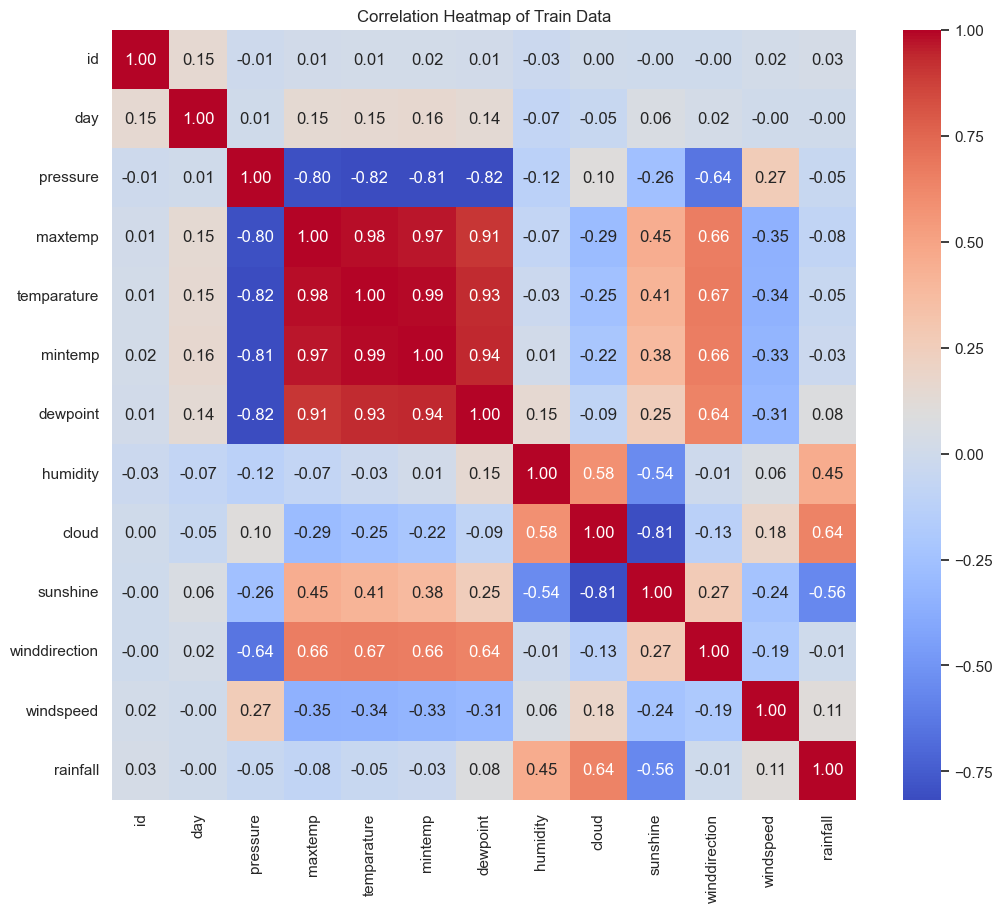

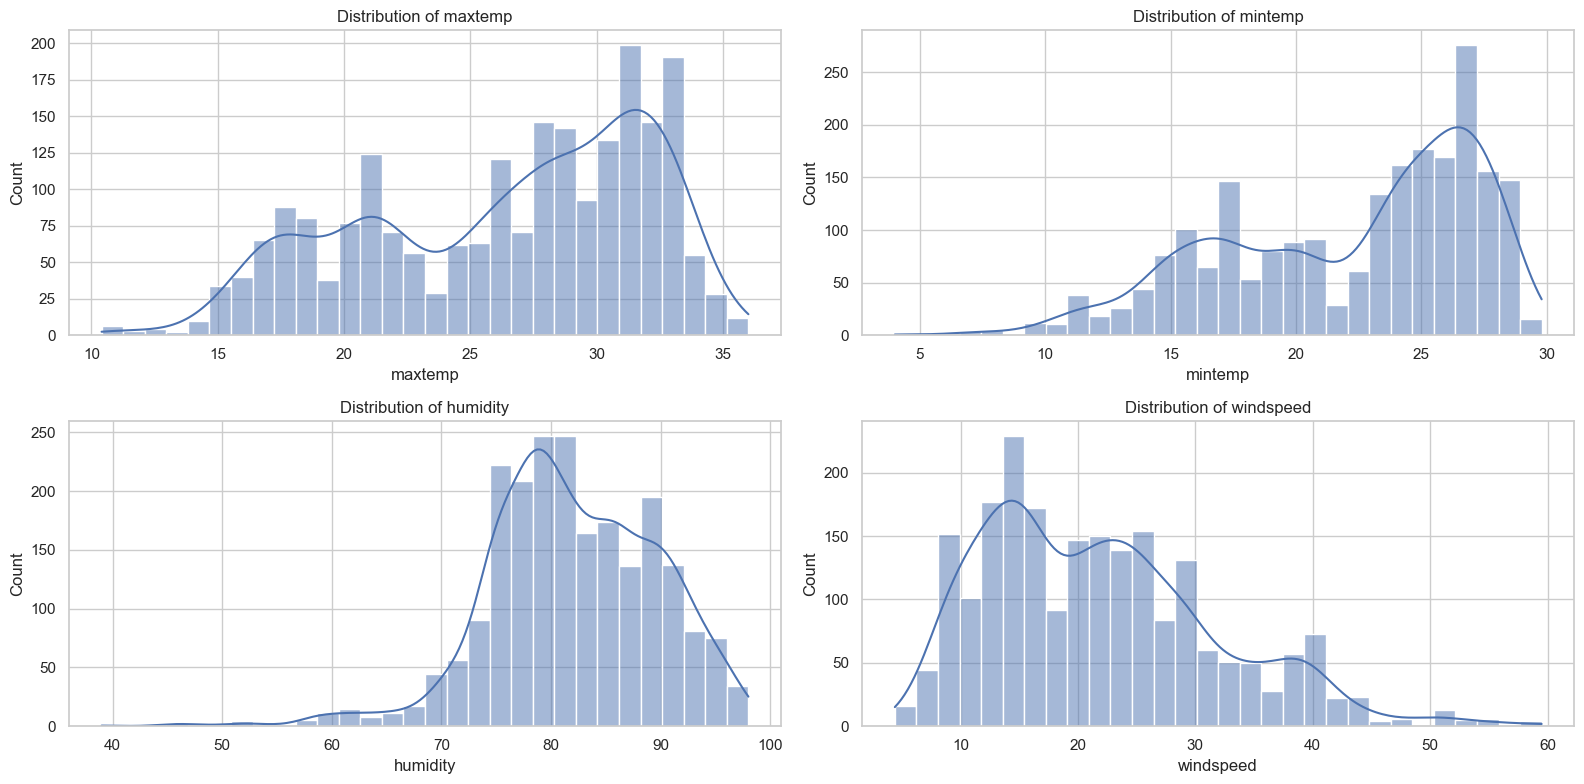

In [3]:
# SECTION 3: Exploratory Data Analysis (EDA)

# Statistical summary of the training data
print("Statistical Summary:")
print(train.describe())

# Plot a correlation heatmap to understand feature relationships
plt.figure(figsize=(12, 10))
corr_matrix = train.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Train Data")
plt.show()

# Plot distributions for a few key features
features_to_plot = ['maxtemp', 'mintemp', 'humidity', 'windspeed']
plt.figure(figsize=(16, 8))
for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 2, i + 1)
    sns.histplot(train[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

In [4]:
# SECTION 4: Data Preprocessing & Feature Engineering

def process_data(df, is_train=True):
    """
    Preprocess and perform feature engineering on the dataset.
    Parameters:
        df (pd.DataFrame): Input dataframe (train or test).
        is_train (bool): True if processing training data (ensures target handling).
    Returns:
        df (pd.DataFrame): Processed dataframe.
    """
    # Fill missing values with median
    df.fillna(df.median(), inplace=True)
    
    # Create a new feature: temperature range (maxtemp - mintemp)
    df['temp_range'] = df['maxtemp'] - df['mintemp']
    
    # Additional interaction features
    df['hci'] = df['humidity'] * df['cloud']
    df['hsi'] = df['humidity'] * df['sunshine']
    df['csr'] = df['cloud'] / (df['sunshine'] + 1e-5)
    df['rd'] = 100 - df['humidity']
    df['sp'] = df['sunshine'] / (df['sunshine'] + df['cloud'] + 1e-5)
    df['wi'] = (0.4 * df['humidity']) + (0.3 * df['cloud']) - (0.3 * df['sunshine'])
    
    # Encode categorical variables if any exist
    categorical_cols = df.select_dtypes(include=['object']).columns
    encoder = LabelEncoder()
    for col in categorical_cols:
        df[col] = encoder.fit_transform(df[col])
    
    # For training data, ensure 'rainfall' is the last column
    if is_train and 'rainfall' in df.columns:
        feature_cols = [col for col in df.columns if col != 'rainfall']
        df = df[feature_cols + ['rainfall']]
    
    return df

# Apply preprocessing to both train and test datasets
train = process_data(train, is_train=True)
test = process_data(test, is_train=False)

# Verify column order
print("Processed Train Columns:", train.columns.tolist())
print("Processed Test Columns:", test.columns.tolist())

Processed Train Columns: ['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed', 'temp_range', 'hci', 'hsi', 'csr', 'rd', 'sp', 'wi', 'rainfall']
Processed Test Columns: ['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed', 'temp_range', 'hci', 'hsi', 'csr', 'rd', 'sp', 'wi']


In [5]:
# SECTION 5: Feature Scaling

# Separate features and target from the training set
X = train.drop(columns=['rainfall'])
y = train['rainfall']

# Apply standard scaling to numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Scale test set features using the same scaler
test_scaled = scaler.transform(test)

# Print shapes to confirm scaling
print("Scaled Train Features Shape:", X_scaled.shape)
print("Scaled Test Features Shape:", test_scaled.shape)

Scaled Train Features Shape: (2190, 19)
Scaled Test Features Shape: (730, 19)


In [6]:
# SECTION 6: Data Augmentation & Train/Validation Split (Triple the Data Size)

# Step 1: Generate synthetic copies by adding small Gaussian noise to the original scaled data
noise_factor = 0.001  # Adjust noise level as needed

# Generate two synthetic datasets
X_synthetic1 = X_scaled + noise_factor * np.random.normal(size=X_scaled.shape)
X_synthetic2 = X_scaled + noise_factor * np.random.normal(size=X_scaled.shape)
y_synthetic1 = y.copy()  # Labels remain the same for synthetic data
y_synthetic2 = y.copy()

# Step 2: Combine original data with the two synthetic copies to triple the dataset size
X_augmented = np.vstack((X_scaled, X_synthetic1, X_synthetic2))
y_augmented = np.hstack((y, y_synthetic1, y_synthetic2))

print("Original dataset size:", X_scaled.shape[0])
print("Augmented dataset size (tripled):", X_augmented.shape[0])

# Step 3: Split the augmented data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])

Original dataset size: 2190
Augmented dataset size (tripled): 6570
Training set size: 5256
Validation set size: 1314


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 8)              │             

 Total params: 51,041 (199.38 KB)

 Trainable params: 50,033 (195.44 KB)

 Non-trainable params: 1,008 (3.94 KB)

Epoch 1/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6265 - auc: 0.7357 - loss: 0.6639 - val_accuracy: 0.8645 - val_auc: 0.8755 - val_loss: 0.4222
Epoch 2/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8492 - auc: 0.8712 - loss: 0.4234 - val_accuracy: 0.8600 - val_auc: 0.8920 - val_loss: 0.3524
Epoch 3/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8524 - auc: 0.8753 - loss: 0.3741 - val_accuracy: 0.8683 - val_auc: 0.8936 - val_loss: 0.3310
Epoch 4/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8510 - auc: 0.8771 - loss: 0.3637 - val_accuracy: 0.8645 - val_auc: 0.8923 - val_loss: 0.3266
Epoch 5/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8609 - auc: 0.8883 - loss: 0.3398 - val_accuracy: 0.8676 - val_auc: 0.8963 - val_loss: 0.3242
Epoch 6/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8669 - auc: 0.8908 - loss: 0.3385 - val_accuracy: 0.8676 - val_auc: 0.8999 - val_loss: 0.3203
Epoch 7/200
165/165 ━━━━━━━━━━━━━━

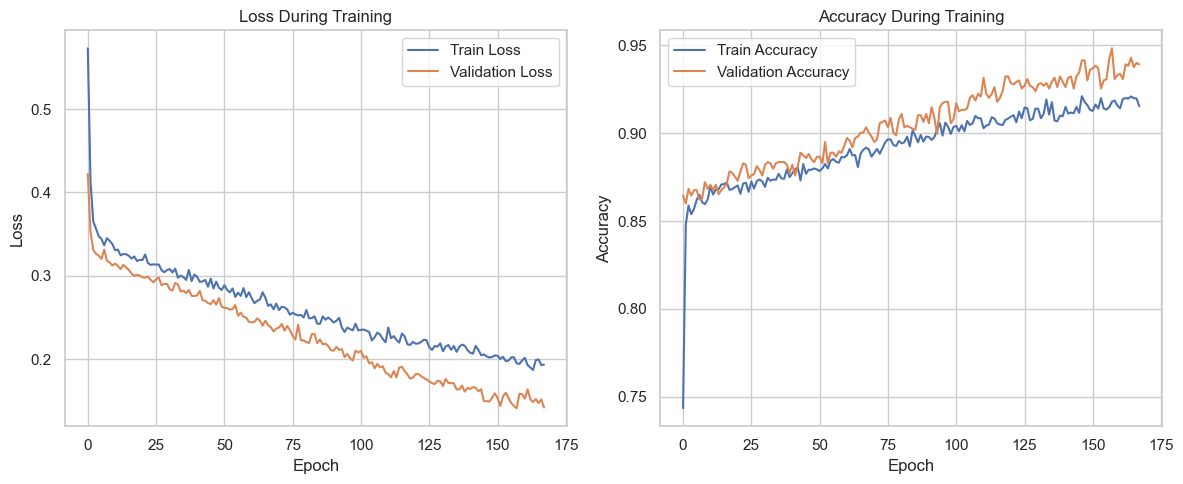

In [7]:
# SECTION 7: Build and Train a 6-Layer DNN Model

# Get the number of input features
input_dim = X_train.shape[1]

# Define the DNN model using the Functional API
inputs = Input(shape=(input_dim,))

# Layer 1: Dense -> BatchNormalization -> ReLU -> Dropout
x = Dense(256)(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)

# Layer 2
x = Dense(128)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)

# Layer 3
x = Dense(64)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)

# Layer 4
x = Dense(32)(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# Layer 5
x = Dense(16)(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# Layer 6
x = Dense(8)(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# Output layer: Sigmoid activation to output probability between 0 and 1
outputs = Dense(1, activation='sigmoid')(x)

# Build and compile the model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])

# Display the model summary
model.summary()

# Set early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=200,
                    batch_size=32,
                    callbacks=[early_stopping])

# Plot training history for loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# SECTION 8: Model Evaluation on Validation Set

# Evaluate model performance on the validation set
val_loss, val_accuracy, val_auc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation AUC: {val_auc:.4f}")

Validation Loss: 0.1412
Validation Accuracy: 0.9482
Validation AUC: 0.9845


In [9]:
# SECTION 9: Predict on Test Set & Generate Submission File

# Predict probabilities on the test set (values between 0 and 1)
test_preds = model.predict(test_scaled)

# Retrieve test IDs (if 'id' column exists, otherwise use index)
test_ids = test['id'] if 'id' in test.columns else test.index

# Create a submission DataFrame with the required format:
# id, rainfall (with rainfall as probability rounded to one decimal place)
submission = pd.DataFrame({
    'id': test_ids,
    'rainfall': test_preds.flatten()
})

# Save the submission file
submission_path = '/Users/luoyi/Desktop/10_kaggle/03_rainfall/submission_dnn_final.csv'
submission.to_csv(submission_path, index=False)

print("Submission file generated!")
print(submission.head())

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Submission file generated!
     id  rainfall
0  2190  0.999424
1  2191  0.999930
2  2192  0.838271
3  2193  0.051907
4  2194  0.000564
